In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install scikit-learn
#!pip install scikit-image



In [2]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from sklearn.metrics import confusion_matrix
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler 
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet

from torchvision import transforms, models, datasets, utils

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


# Inicialização das CNNs

In [4]:
# Tamanho do lote (mini-batch)
batch_size = 32
# Taxa de aprendizado
lr = 0.001
# Mommentum
mm = 0.9
# Número de épocas
epochs = 100 # Usar um valor pequeno durante o desenvolvimento, 2 por exemplo. 
# Step size
ss = 10

In [5]:
ARCH_NAME = 'resnet' # 'efficient', 'resnet', 
num_classes = 2

In [6]:
# Inicialização das CNNs


if ARCH_NAME == "alexnet":
    # AlexNet
    model = models.alexnet(pretrained=True)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    # tamanho = 224

elif ARCH_NAME == "efficient":
    # EfficientNet
    model = EfficientNet.from_pretrained('efficientnet-b0')
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, num_classes)
    # tamanho = 224

elif ARCH_NAME == "resnet":
    # ResNet50
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # tamanho = 224

else:
    print("Invalid model type, exiting...")
    exit()



C:\Users\marcu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marcu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [8]:
# Definir transformações
transformacao = transforms.Compose([
    transforms.Resize((190, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Carregar datasets
base_treinamento = datasets.ImageFolder(root='C:/Users/marcu/Downloads/DataSet/treino', transform=transformacao)
train_dataloader = DataLoader(base_treinamento, batch_size=10, shuffle=True)

base_validacao = datasets.ImageFolder(root='C:/Users/marcu/Downloads/DataSet/validacao', transform=transformacao)
val_dataloader = DataLoader(base_validacao, batch_size=10, shuffle=True)

base_teste = datasets.ImageFolder(root='C:/Users/marcu/Downloads/DataSet/teste', transform=transformacao)
test_dataloader = DataLoader(base_teste, batch_size=1, shuffle=False)


In [9]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador - SGD
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Adjust learning rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (DEVICE)

model = model.to(DEVICE)

cuda


In [11]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Tamanho dos conjuntos de dados
train_size = len(train_dataloader.dataset)
val_size = len(val_dataloader.dataset)
test_size = len(test_dataloader.dataset)


# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

# Learning rate list
lr_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino 
    model.train() 

    # Perda (loss) nesta época
    loss_epoch_train = 0.0    
    # Amostras classificadas corretamente nesta época
    hits_epoch_train = 0  

    # Iterate along the batches of the TRAINING SET
    for inputs, labels, *_ in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE) 

        # Zera os parametros do gradiente
        optimizer.zero_grad() 

        # FORWARD
        # ------>
        # Habilita cálculo do gradiente
        torch.set_grad_enabled(True) 

        # Saída do modelo para o lote
        outputs = model(inputs) 

        #  Tomar o maior valor de 'outputs' como predição.
        preds = torch.argmax(outputs, dim=1).float() 

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward() 

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0) 

        # Atualiza o número de amostras classificadas corretamente na época.
        hits_epoch_train += torch.sum(preds == labels.data) 

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval() 

    # Epoch validation loss
    loss_epoch_val = 0.0 #
    # Num hits for this epoch
    hits_epoch_val = 0 
    
    # Iterate along the batches of the VALIDATION SET
    for inputs, labels, *_ in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad() 

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False) 

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs) 

        # Retorna o maior valor como predição.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels) 

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Atualiza os acertos da época
        hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    scheduler.step() 

    # Store the learning rate
    lr_epoch = optimizer.param_groups[0]['lr']
    lr_list.append(lr_epoch)
        
    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start
    
    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/99 - TRAIN Loss: 0.3589 TRAIN Acc: 0.8474 - VAL. Loss: 0.2773 VAL. Acc: 0.8962 (72.4350 seconds)
Epoch 1/99 - TRAIN Loss: 0.2645 TRAIN Acc: 0.8948 - VAL. Loss: 0.2758 VAL. Acc: 0.8881 (64.1574 seconds)
Epoch 2/99 - TRAIN Loss: 0.1902 TRAIN Acc: 0.9274 - VAL. Loss: 0.1511 VAL. Acc: 0.9395 (63.8251 seconds)
Epoch 3/99 - TRAIN Loss: 0.1406 TRAIN Acc: 0.9503 - VAL. Loss: 0.1251 VAL. Acc: 0.9587 (63.6147 seconds)
Epoch 4/99 - TRAIN Loss: 0.1419 TRAIN Acc: 0.9540 - VAL. Loss: 0.1690 VAL. Acc: 0.9456 (63.9641 seconds)
Epoch 5/99 - TRAIN Loss: 0.0846 TRAIN Acc: 0.9701 - VAL. Loss: 0.1210 VAL. Acc: 0.9607 (63.6608 seconds)
Epoch 6/99 - TRAIN Loss: 0.1088 TRAIN Acc: 0.9684 - VAL. Loss: 0.1394 VAL. Acc: 0.9506 (63.7202 seconds)
Epoch 7/99 - TRAIN Loss: 0.0480 TRAIN Acc: 0.9832 - VAL. Loss: 0.1391 VAL. Acc: 0.9496 (63.9198 seconds)
Epoch 8/99 - TRAIN Loss: 0.0579 TRAIN Acc: 0.9815 - VAL. Loss: 0.1441 VAL. Acc: 0.9577 (63.9334 seconds)
Epoch 9/99 - TRAIN Loss: 0.0807 TRAIN Acc: 0.9768 - VAL

In [12]:
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, model_name, fold, save_dir):
    """
    Plots the loss and accuracy graphs per epoch for training and validation sets.

    Args:
        train_losses (list): List of training set loss values per epoch.
        val_losses (list): List of validation set loss values per epoch.
        train_accs (list): List of training set accuracy values per epoch.
        val_accs (list): List of validation set accuracy values per epoch.
        model_name (str): Name of the model.
        fold (int): Fold number.
        save_dir (str): Directory to save the plots.

    Returns:
        None
    """
    # Define the number of epochs
    epochs = len(train_losses)

    # Define the x-axis of the graph as the number of epochs
    x = range(1, epochs + 1)

    # Plot the graphs of loss and accuracy for the training and validation sets
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses, c='red', ls='-', label='Train loss', fillstyle='none')
    plt.plot(x, val_losses, c='blue', ls='--', label='Val. loss', fillstyle='none')
    plt.title('Erro')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, train_accs, c='red', ls='-', label='Train accuracy', fillstyle='none')
    plt.plot(x, val_accs, c='blue', ls='--', label='Val. accuracy', fillstyle='none')
    plt.title('Acurácia')
    plt.legend()

    plt.savefig(f'{save_dir}/{model_name}_fold{fold}_loss_acc.pdf')
    plt.show()


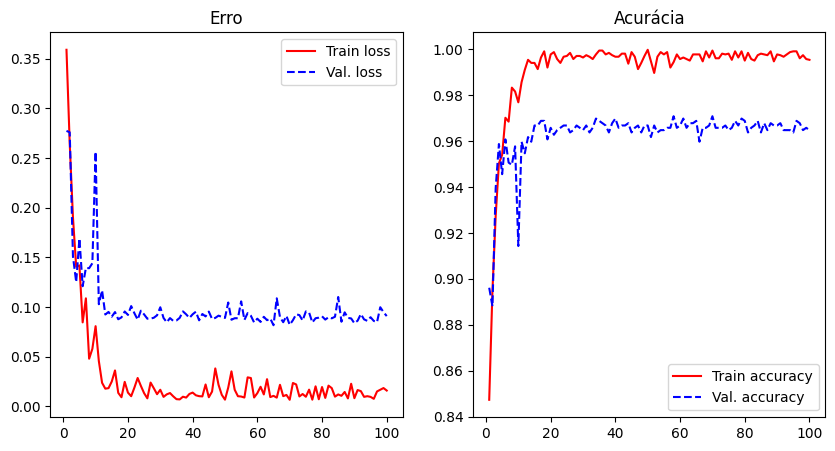

In [13]:
# Nome do modelo e diretório para salvar os gráficos
model_name = "meu_modelo"  # Substitua pelo nome do modelo
fold = 1  # Substitua pelo número do fold, caso esteja utilizando cross-validation
save_dir = "./plots"  # Diretório onde deseja salvar os gráficos

# Criar o diretório, se não existir
os.makedirs(save_dir, exist_ok=True)

# Chamada da função para plotar os gráficos
plot_loss_accuracy(
    train_losses=train_loss_list,
    val_losses=val_loss_list,
    train_accs=train_acc_list,
    val_accs=val_acc_list,
    model_name=model_name,
    fold=fold,
    save_dir=save_dir
)

In [14]:
# Lista com as classes reais e classes preditas
true_test_list = []
pred_test_list = []
# Lista com as probabilidades
prob_test_list = []
# lista com os caminhos para as imagens
path_test_list = []

# Iterate along the batches of the TEST SET
for i, (img_list, label_list) in enumerate(test_dataloader):
    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        label_list = label_list.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades 
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_test_batch = list(outputs_prob.cpu())

    # Classes reais (true) e classes preditas (pred) para este lote.
    true_test_batch = list(label_list.cpu()) if DEVICE.type == 'cuda' else list(label_list)
    pred_test_batch = list(preds.cpu()) if DEVICE.type == 'cuda' else list(preds)

    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch
    prob_test_list += prob_test_batch


In [15]:
## Supondo que você tenha o dataset com rótulos
dataset = test_dataloader.dataset
classes = dataset.classes  # Se o dataset for um dataset do PyTorch, por exemplo
print(classes)

# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix (test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list, 
                                               pred_test_list, 
                                               target_names=classes, 
                                               digits=4,
                                               zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_test))


['benign', 'malignant']

Confusion matrix (test set)
[[468  28]
 [ 18 478]]

Class. report (test set)
              precision    recall  f1-score   support

      benign     0.9630    0.9435    0.9532       496
   malignant     0.9447    0.9637    0.9541       496

    accuracy                         0.9536       992
   macro avg     0.9538    0.9536    0.9536       992
weighted avg     0.9538    0.9536    0.9536       992



Validation Acc.: 0.9536


Confusion Matrix:
 [[468  28]
 [ 18 478]]
Matrix Accuracy: 0.9536


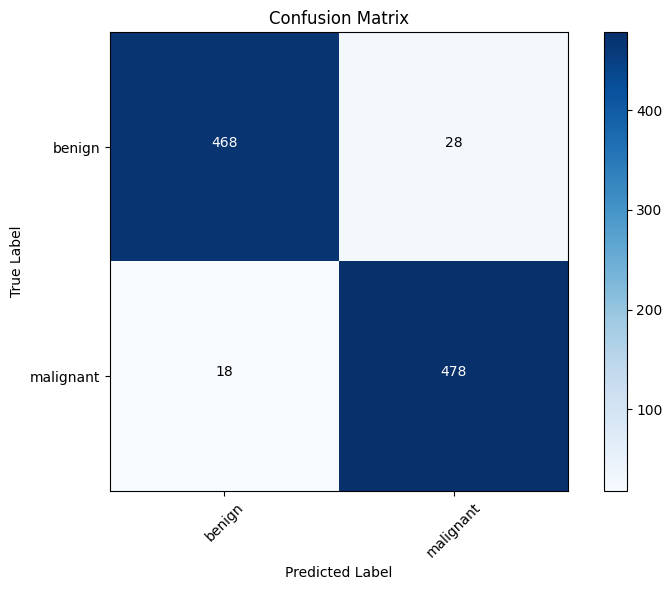

In [16]:
# Converta para arrays NumPy
y_true = np.array(true_test_list, dtype=int)
y_pred = np.array(pred_test_list, dtype=int)

# Calcule a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Print matriz e acurácia derivada da matriz
print("Confusion Matrix:\n", conf_matrix)
matrix_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Matrix Accuracy: {matrix_accuracy:.4f}")

# Visualize a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adicione os nomes das classes
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['benign', 'malignant'], rotation=45)
plt.yticks(tick_marks, ['benign', 'malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adicione valores na matriz
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'confusion_matrix.pdf'))
plt.show()